In [2]:
# ====== Imports ======
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import joblib

sns.set_style("whitegrid")

In [3]:
# ====== 0. Print current working directory (debug helper) ======
print("Current working directory:", os.getcwd())

Current working directory: /Users/faezehmeyari/Desktop/ml-learning-notes/Supervised Learning/Regression/Multiple linear regression/notebookes


In [27]:
# ====== 1. Load dataset (relative path from notebooks/ to data/) ======
# If your notebook is in notebooks/, dataset is ../data/Student_Performance.csv
df = pd.read_csv("../data/Student_Performance.csv")


# Clean column names from unexpected leading/trailing spaces
df.columns = df.columns.str.strip()

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

# Quick peek
display(df.head())


Dataset shape: (10000, 6)
Columns: ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index']


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [28]:
# بررسی ابعاد داده (تعداد سطر و ستون)
print("Shape:", df.shape)

# نمایش اطلاعات کلی درباره‌ی نوع داده‌ها و null بودنشان
df.info()

# بررسی آماری متغیرها
df.describe()

Shape: (10000, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [6]:
# ====== 2. Basic EDA checks ======
print("\nMissing values per column:\n", df.isnull().sum())



Missing values per column:
 Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64


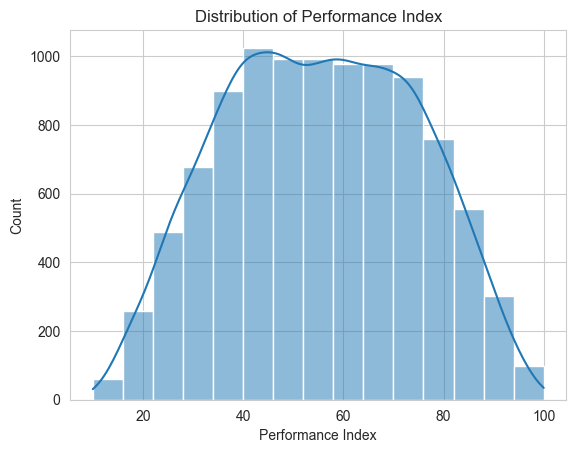

In [29]:
sns.histplot(df['Performance Index'], bins=15, kde=True)
plt.title('Distribution of Performance Index')
plt.show()

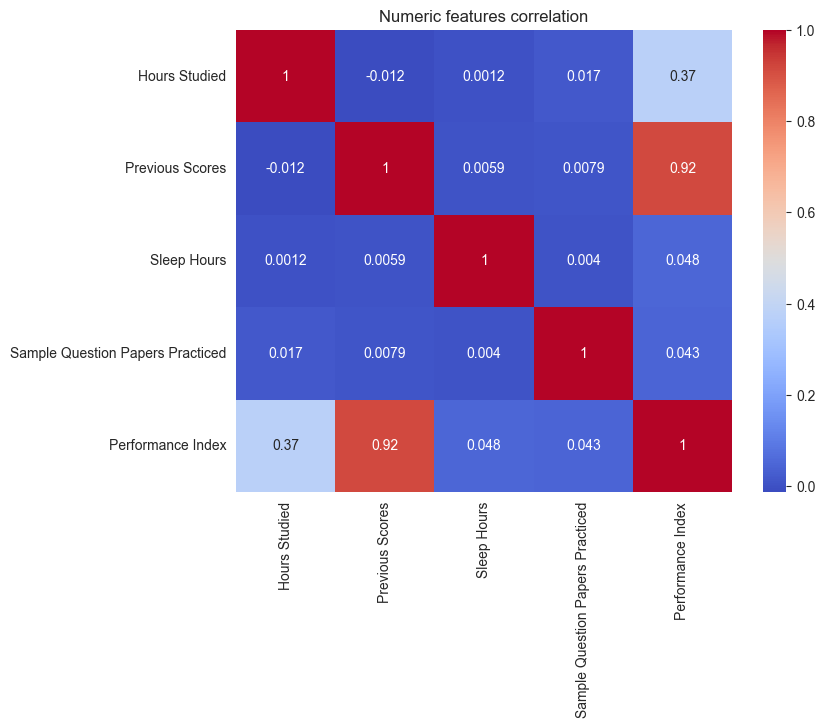

In [7]:
# If you want numeric-only correlation heatmap:
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(8,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Numeric features correlation")
plt.show()

In [8]:
# ====== 3. Define features and target (according to your dataset) ======
X = df[['Hours Studied',
        'Previous Scores',
        'Extracurricular Activities',
        'Sleep Hours',
        'Sample Question Papers Practiced']].copy()

y = df['Performance Index'].copy()


In [9]:
# ====== 4. Split into train and test (ONLY ONCE) ======
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")


X_train: (8000, 5), X_test: (2000, 5)


In [10]:
# ====== 5. Encode categorical columns (fit only on train, then transform test) ======
# Detect object (string) columns and encode them with LabelEncoder (simple approach)
# If you have ordinal categories, consider proper mapping instead.
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

label_encoders = {}  # to keep each encoder if needed later

for col in X_train_enc.columns:
    if X_train_enc[col].dtype == 'object':
        le = LabelEncoder()
        # Fit on train, transform both
        X_train_enc[col] = le.fit_transform(X_train_enc[col].astype(str))
        X_test_enc[col] = le.transform(X_test_enc[col].astype(str))
        label_encoders[col] = le

# Confirm all are numeric now
print("\nFeature dtypes after encoding (train):")
print(X_train_enc.dtypes)


Feature dtypes after encoding (train):
Hours Studied                       int64
Previous Scores                     int64
Extracurricular Activities          int64
Sleep Hours                         int64
Sample Question Papers Practiced    int64
dtype: object


In [11]:
# ====== 6. Feature scaling (Standardization) ======
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

# If you want DataFrame view of scaled features:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_enc.columns, index=X_train_enc.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_enc.columns, index=X_test_enc.index)

display(X_train_scaled_df.head())


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced
9254,0.006455,-1.183844,-0.989307,0.269888,0.134041
1561,-1.149747,-1.241506,1.010808,0.269888,0.483562
1670,-1.149747,0.661318,-0.989307,0.269888,-0.914520
6087,-1.149747,-1.356828,-0.989307,-0.318906,-1.264041
6669,1.162658,-1.299167,-0.989307,1.447477,-1.613561


In [12]:
# ====== 7. Train Multiple Linear Regression model ======
model = LinearRegression()
model.fit(X_train_scaled, y_train)

print("\nModel trained successfully.")



Model trained successfully.


In [13]:
# ====== 8. Predict on test set ======
y_pred = model.predict(X_test_scaled)


In [14]:
# ====== 9. Evaluate ======
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"\nEvaluation on test set:")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")



Evaluation on test set:
R² Score: 0.9890
MSE: 4.0826
RMSE: 2.0206


In [15]:
# ====== 10. Coefficients (map back to feature names) ======
coeff_df = pd.DataFrame({
    "Feature": X_train_enc.columns,
    "Coefficient": model.coef_
}).sort_values(by='Coefficient', key=lambda s: s.abs(), ascending=False)

print("\nModel coefficients:")
display(coeff_df)

print("\nIntercept:", model.intercept_)



Model coefficients:


,Feature,Coefficient
1,Previous Scores,17.637271
0,Hours Studied,7.401341
3,Sleep Hours,0.810031
4,Sample Question Papers Practiced,0.548842
2,Extracurricular Activities,0.304291



Intercept: 55.31150000000001


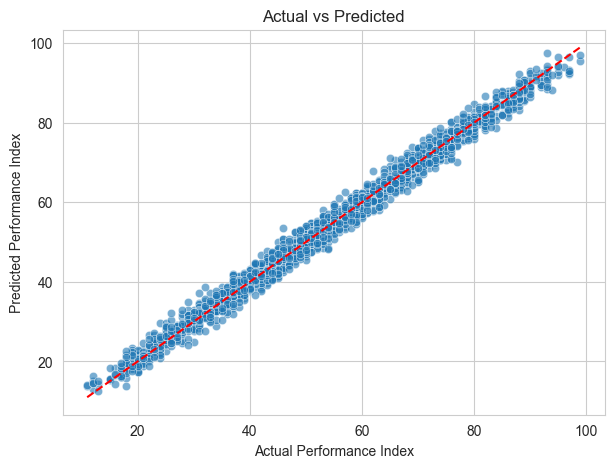

In [16]:
# ====== 11. Visualizations ======
# Actual vs Predicted
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Performance Index")
plt.ylabel("Predicted Performance Index")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()


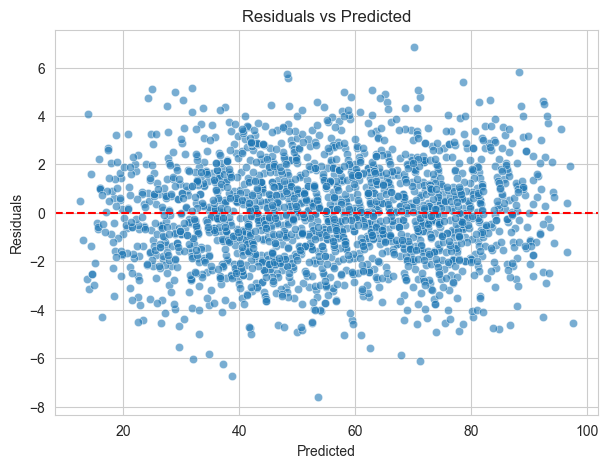

In [17]:
# Residuals
residuals = y_test - y_pred
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.show()


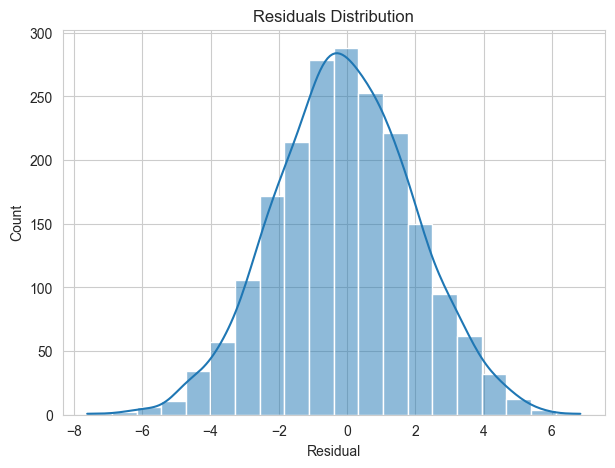

In [18]:
# Residuals distribution
plt.figure(figsize=(7,5))
sns.histplot(residuals, bins=20, kde=True)
plt.xlabel("Residual")
plt.title("Residuals Distribution")
plt.grid(True)
plt.show()


In [19]:
# ====== 12. Save the trained model and preprocessing objects ======
os.makedirs("../models", exist_ok=True)
joblib.dump(model, "../models/linear_regression_model.pkl")
joblib.dump(scaler, "../models/standard_scaler.pkl")
joblib.dump(label_encoders, "../models/label_encoders.pkl")
print("\nSaved model and preprocessors to ../models/")



Saved model and preprocessors to ../models/


In [20]:
# ====== 13. Example: load model and predict a new sample ======
# Note: when predicting new raw data, you must apply the same encoding and scaling pipeline
# Example raw sample (dict) - replace values as needed
sample_raw = {
    "Hours Studied": 3.5,
    "Previous Scores": 70,
    "Extracurricular Activities": "Yes",   # if this column originally contained Yes/No
    "Sleep Hours": 7,
    "Sample Question Papers Practiced": 2
}


In [21]:
# Convert to DataFrame
sample_df = pd.DataFrame([sample_raw])


In [22]:
# Encode using saved label_encoders (if column was encoded)
for col, le in label_encoders.items():
    sample_df[col] = le.transform(sample_df[col].astype(str))


In [23]:
# Scale
sample_scaled = scaler.transform(sample_df[X_train_enc.columns])


In [24]:
# Predict
sample_pred = model.predict(sample_scaled)
print(f"\nExample sample prediction → Predicted Performance Index: {sample_pred[0]:.3f}")


Example sample prediction → Predicted Performance Index: 51.582
